In [ ]:
# Install required libraries
!pip install opencv-python
!pip install opencv-python-headless

# Download MobileNet-SSD prototxt and weights
!wget -O deploy.prototxt https://raw.githubusercontent.com/chuanqi305/MobileNet-SSD/master/deploy.prototxt
!wget -O mobilenet_iter_73000.caffemodel https://github.com/chuanqi305/MobileNet-SSD/raw/master/mobilenet_iter_73000.caffemodel


--2024-01-27 07:15:43--  https://raw.githubusercontent.com/chuanqi305/MobileNet-SSD/master/deploy.prototxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44667 (44K) [text/plain]
Saving to: ‘deploy.prototxt’

deploy.prototxt     100%[===================>]  43.62K  --.-KB/s    in 0.01s   

2024-01-27 07:15:44 (4.20 MB/s) - ‘deploy.prototxt’ saved [44667/44667]

--2024-01-27 07:15:44--  https://github.com/chuanqi305/MobileNet-SSD/raw/master/mobilenet_iter_73000.caffemodel
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/chuanqi305/MobileNet-SSD/master/mobilenet_iter_73000.caffemodel [following]
--

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading existing clothing model...
Loading existing color model...
{0: 'dress', 1: 'dress sweater', 2: 'dress_multiple', 3: 'jacket', 4: 'jacket pants', 5: 'jacket_multiple', 6: 'pants', 7: 'pants shirt', 8: 'pants shirt sweater', 9: 'pants sweater', 10: 'pants_multiple', 11: 'shirt short', 12: 'shirt skirt', 13: 'shirt_multiple', 14: 'shirt_multiple skirt_multiple', 15: 'short', 16: 'short sweater', 17: 'skirt', 18: 'skirt sweater', 19: 'skirt_multiple', 20: 'skirt_multiple sweater_multiple', 21: 'sweater', 22: 'sweater_multiple', 23: 'Tshirt', 24: 'Tshirt pants', 25: 'Tshirt pants_multiple sweater', 26: 'Tshirt skirt', 27: 'Tshirt sweater', 28: 'Tshirt_multiple', 29: 'Tshirt_multiple pants skirt'}


Saving download (2).jpeg to download (2) (1).jpeg
Displaying Traced Upper Body:


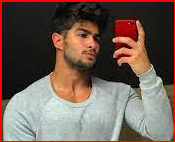

1/1 [==============================] - 0s 77ms/step
Upper Body Clothing Type Prediction: sweater
Displaying Traced Lower Body:


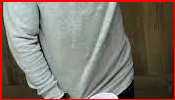

1/1 [==============================] - 0s 21ms/step
Lower Body Clothing Type Prediction: dress
Displaying Traced Upper Body:


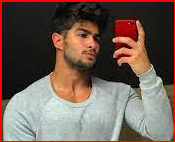

Displaying Traced Lower Body:


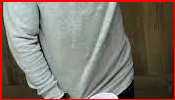

Displaying Result Image:


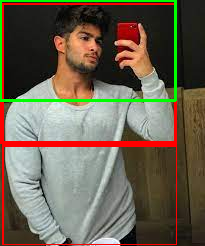

1/1 [==============================] - 0s 86ms/step
Color prediction: Gray


In [5]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model, save_model
from tensorflow.keras import layers, models
from google.colab import drive
from PIL import Image
from google.colab import files
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import fashion_mnist
from google.colab.patches import cv2_imshow

# Mount Google Drive
drive.mount('/content/drive')

# Load pre-trained SSD model for person detection
# Corrected paths for the DNN model and weights
model_path = "/content/drive/MyDrive/Colab Notebooks/deploy.prototxt"
weights_path = "/content/drive/MyDrive/Colab Notebooks/mobilenet_iter_73000.caffemodel"
net = cv2.dnn.readNetFromCaffe(model_path, weights_path)

def detect_person(image):
    height, width = image.shape[:2]

    # Preprocess the image for SSD
    blob = cv2.dnn.blobFromImage(image, 0.007843, (300, 300), 127.5)

    # Set the input to the network and perform inference
    net.setInput(blob)
    detections = net.forward()

    # Initialize variables to store upper body, lower body, and full person images
    upper_body = None
    lower_body = None
    full_person = None

    # Loop over the detections
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > 0.2:  # Confidence threshold
            class_id = int(detections[0, 0, i, 1])
            if class_id == 15:  # Class ID for person in COCO dataset
                # Extract the bounding box coordinates
                box = detections[0, 0, i, 3:7] * np.array([width, height, width, height])
                (startX, startY, endX, endY) = box.astype(int)

                # Ensure the bounding box coordinates are within the image dimensions
                startX = max(0, startX)
                startY = max(0, startY)
                endX = min(width - 1, endX)
                endY = min(height - 1, endY)

                # Extract the region of interest (ROI) containing the person
                full_person = image[startY:endY, startX:endX]

                # Define the upper and lower body regions with fractional midpoint
                midY_factor = 1.7# Adjust this factor as needed
                midY = startY + (endY - startY) / midY_factor
                upper_body = image[startY:int(midY), startX:endX]
                lower_body = image[int(midY):endY, startX:endX]

                # Return the upper body, lower body, and full person images
                return upper_body, lower_body, full_person

    # Return None for upper body, lower body, and full person if no person is detected
    return None, None, None


class_labels = ['dress', 'dress sweater', 'dress_multiple', 'jacket', 'jacket pants', 'jacket_multiple', 'pants', 'pants shirt', 'pants shirt sweater', 'pants sweater', 'pants_multiple', 'shirt short', 'shirt skirt', 'shirt_multiple', 'shirt_multiple skirt_multiple', 'short', 'short sweater', 'skirt', 'skirt sweater', 'skirt_multiple', 'skirt_multiple sweater_multiple', 'sweater', 'sweater_multiple', 'Tshirt', 'Tshirt pants', 'Tshirt pants_multiple sweater', 'Tshirt skirt', 'Tshirt sweater', 'Tshirt_multiple', 'Tshirt_multiple pants skirt']

# Create clothing_type_mapping dictionary
clothing_type_mapping = {i: class_labels[i] for i in range(len(class_labels))}

# Function to trace and predict dress
def trace_and_predict_dress(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply thresholding to separate the dress from the background
    _, binary_mask = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)

    # Find contours of the dress region
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Assuming the largest contour corresponds to the dress
    largest_contour = max(contours, key=cv2.contourArea)

    # Extract the region of interest (ROI) containing the dress
    x, y, w, h = cv2.boundingRect(largest_contour)
    traced_dress_roi = image[y:y+h, x:x+w]

    # Draw the traced dress region in blue color
    cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)

    # Display the traced dress region
    print("Displaying Traced Dress Region:")
    cv2_imshow(image)

    # Resize the traced dress to the input shape expected by the clothing model
    traced_dress_resized = cv2.resize(traced_dress_roi, (28, 28))

    # Convert the resized image to RGB
    traced_dress_rgb = cv2.cvtColor(traced_dress_resized, cv2.COLOR_BGR2RGB)

    # Normalize pixel values
    traced_dress_normalized = traced_dress_rgb / 255.0

    # Expand dimensions to match the model input shape
    traced_dress_normalized = np.expand_dims(traced_dress_normalized, axis=0)

    # Make predictions for clothing type using the clothing model
    clothing_prediction = clothing_model.predict(traced_dress_normalized)
    clothing_prediction = np.argmax(clothing_prediction, axis=1)[0]

    print(f'Dress Type Prediction: {clothing_type_mapping[clothing_prediction]}')

    # Resize the traced dress to the input shape expected by the color model
    traced_dress_resized_color = cv2.resize(traced_dress_roi, (224, 224))

    # Convert the resized image to RGB
    traced_dress_rgb = cv2.cvtColor(traced_dress_resized_color, cv2.COLOR_BGR2RGB)

    # Normalize pixel values
    traced_dress_normalized_color = traced_dress_rgb / 255.0

    # Expand dimensions to match the model input shape
    traced_dress_normalized_color = np.expand_dims(traced_dress_normalized_color, axis=0)

    # Make predictions for color using the color model
    color_prediction = color_model.predict(traced_dress_normalized_color)
    color_prediction = np.argmax(color_prediction, axis=1)[0]

    print(f'Dress Color Prediction: {color_mapping[color_prediction]}')

    # Return the predictions
    return traced_dress_normalized, traced_dress_normalized_color, clothing_prediction


# Function to load or train the clothing model
def load_or_train_clothing_model():
    model_path = "/content/drive/MyDrive/Colab Notebooks/clothing_model.h5"

    if os.path.isfile(model_path):
        # Load the existing model if it exists
        print("Loading existing clothing model...")
        return load_model(model_path)
    else:
        # Train the model if it doesn't exist
        print("Training new clothing model...")

        # Replace this path with the path to your dataset in Google Drive
        dataset_path = "/content/drive/MyDrive/Colab Notebooks/valid"

        # Create a mapping from folder names to clothing types
        clothing_mapping = {folder_name: index for index, folder_name in enumerate(os.listdir(dataset_path))}
        num_classes = len(clothing_mapping)

        images = []
        clothing_labels = []

        for folder_name in os.listdir(dataset_path):
            folder_path = os.path.join(dataset_path, folder_name)
            clothing_label = clothing_mapping[folder_name]

            for image_file in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_file)
                images.append(image_path)
                clothing_labels.append(clothing_label)

        # Preprocess images and labels
        X_clothing = []
        y_clothing = []

        for image_path, clothing_label in zip(images, clothing_labels):
            image = cv2.imread(image_path)
            image = cv2.resize(image, (28, 28))  # Resize images to a consistent size
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
            image = image / 255.0  # Normalize pixel values
            X_clothing.append(image)
            y_clothing.append(clothing_label)

        X_clothing = np.array(X_clothing)
        y_clothing = np.array(y_clothing)

        # Reshape data to add a channel dimension (assuming RGB images)
        X_clothing = X_clothing.reshape(X_clothing.shape + (1,))

        # Define a simple CNN model for clothing classification
        clothing_model = models.Sequential([
            layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3)),
            layers.MaxPooling2D((2, 2)),
            layers.Flatten(),
            layers.Dense(64, activation='relu'),
            layers.Dense(num_classes, activation='softmax', name='clothing_type')
        ])

        # Compile the clothing model
        clothing_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        # Train the clothing model on the dataset
        clothing_model.fit(X_clothing, y_clothing, epochs=23, validation_split=0.1)

        # Save the trained model to the specified path
        save_model(clothing_model, model_path)

        return clothing_model

# Function to load or train the color model
def load_or_train_color_model():
    model_path = "/content/drive/MyDrive/Colab Notebooks/color_model.h5"

    if os.path.isfile(model_path):
        # Load the existing model if it exists
        print("Loading existing color model...")
        return load_model(model_path)
    else:
        # Train the model if it doesn't exist
        print("Training new color model...")

        # Replace this path with the path to your dataset in Google Drive
        dataset_path = "/content/drive/MyDrive/Colab Notebooks/train"

        color_mapping = {"black": 0, "blue": 1, "brown": 2, "empty": 3, "gray": 4, "green": 5, "orange": 6, "purple": 7, "red": 8, "white": 9, "yellow": 10}

        images = []
        color_labels = []

        for color_folder in os.listdir(dataset_path):
            color_path = os.path.join(dataset_path, color_folder)
            color_label = color_mapping[color_folder]

            for image_file in os.listdir(color_path):
                image_path = os.path.join(color_path, image_file)
                images.append(image_path)
                color_labels.append(color_label)

        # Preprocess images and labels
        X_color = []
        y_color = []

        for image_path, color_label in zip(images, color_labels):
            image = cv2.imread(image_path)
            image = cv2.resize(image, (224, 224))  # Resize images to a consistent size
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
            image = image / 255.0  # Normalize pixel values
            X_color.append(image)
            y_color.append(color_label)

        X_color = np.array(X_color)
        y_color = np.array(y_color)

        # Split the color dataset into training and testing sets
        X_train_color, X_test_color, y_train_color, y_test_color = train_test_split(X_color, y_color, test_size=0.2, random_state=42)

        # Define a simple convolutional neural network for color classification
        color_model = models.Sequential([
            layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
            layers.MaxPooling2D((2, 2)),
            layers.Flatten(),
            layers.Dense(64, activation='relu'),
            layers.Dense(len(color_mapping), activation='softmax', name='color')
        ])

        # Compile the color model
        color_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        # Train the color model
        color_model.fit(X_train_color, y_train_color, epochs=10, validation_data=(X_test_color, y_test_color))

        # Save the trained model
        save_model(color_model, model_path)

        return color_model

# Load or train the clothing model
clothing_model = load_or_train_clothing_model()

# Load or train the color model
color_model = load_or_train_color_model()

# Replace this list with your actual class labels
class_labels = ['dress', 'dress sweater', 'dress_multiple', 'jacket', 'jacket pants', 'jacket_multiple', 'pants', 'pants shirt', 'pants shirt sweater', 'pants sweater','pants_multiple','shirt short','shirt skirt','shirt_multiple','shirt_multiple skirt_multiple','short','short sweater','skirt','skirt sweater','skirt_multiple','skirt_multiple sweater_multiple','sweater','sweater_multiple','Tshirt','Tshirt pants','Tshirt pants_multiple sweater','Tshirt skirt','Tshirt sweater','Tshirt_multiple','Tshirt_multiple pants skirt']

# Create clothing_type_mapping dictionary
clothing_type_mapping = {i: class_labels[i] for i in range(len(class_labels))}

# Print the dictionary
print(clothing_type_mapping)


# Mapping for colors
color_mapping = {0: 'Black', 1: 'Blue', 2: 'Brown', 3: 'Empty', 4: 'Gray', 5: 'Green', 6: 'Orange', 7: 'Purple', 8: 'Red', 9: 'White', 10: 'Yellow'}

def process_image(image_path):
    # Read the image from bytes
    image = cv2.imread(image_path)

    # Detect upper body, lower body, and full person
    upper_body, lower_body, full_person = detect_person(image)

    if full_person is not None:
        # Trace and predict upper body and lower body
        trace_and_predict_upper_body(upper_body)
        trace_and_predict_lower_body(lower_body)

        # Visualize the traced upper and lower body on the original image
        visualize_traced_regions(image, upper_body, lower_body)

        # Process the original image and make predictions for color
        image_original = cv2.cvtColor(full_person, cv2.COLOR_BGR2RGB)  # Convert to RGB
        image_resized = cv2.resize(image_original, (224, 224))

        # Make predictions on color using the color model
        color_prediction = color_model.predict(np.expand_dims(image_resized, axis=0))
        color_prediction = np.argmax(color_prediction, axis=1)[0]

        # Display predictions
        print(f'Color prediction: {color_mapping[color_prediction]}')
    else:
        # Trace and predict dress when no person is detected
        trace_and_predict_dress(image)

def trace_and_predict_upper_body(upper_body):
    if upper_body is not None:
        # Trace the upper body
        trace_and_visualize_region(upper_body, "Upper Body")

        # Resize the traced upper body to a consistent size
        upper_body_resized = cv2.resize(upper_body, (28, 28))  # Resize to match the clothing model input size

        # Convert the resized image to RGB (not grayscale)
        upper_body_resized_rgb = cv2.cvtColor(upper_body_resized, cv2.COLOR_BGR2RGB)

        # Normalize pixel values
        upper_body_resized_normalized = upper_body_resized_rgb / 255.0

        # Expand dimensions to match the model input shape
        upper_body_resized_normalized = np.expand_dims(upper_body_resized_normalized, axis=0)

        # Make predictions for upper body clothing type using the clothing model
        upper_clothing_prediction = clothing_model.predict(upper_body_resized_normalized)
        upper_clothing_prediction = np.argmax(upper_clothing_prediction, axis=1)[0]

        print(f'Upper Body Clothing Type Prediction: {clothing_type_mapping[upper_clothing_prediction]}')


def trace_and_predict_lower_body(lower_body):
    if lower_body is not None:
        # Trace the lower body
        trace_and_visualize_region(lower_body, "Lower Body")

        # Resize the traced lower body to a consistent size
        lower_body_resized = cv2.resize(lower_body, (28, 28))  # Resize to match the clothing model input size

        # Convert the resized image to RGB (not grayscale)
        lower_body_resized_rgb = cv2.cvtColor(lower_body_resized, cv2.COLOR_BGR2RGB)

        # Normalize pixel values
        lower_body_resized_normalized = lower_body_resized_rgb / 255.0

        # Expand dimensions to match the model input shape
        lower_body_resized_normalized = np.expand_dims(lower_body_resized_normalized, axis=0)

        # Make predictions for lower body clothing type using the clothing model
        lower_clothing_prediction = clothing_model.predict(lower_body_resized_normalized)
        lower_clothing_prediction = np.argmax(lower_clothing_prediction, axis=1)[0]

        print(f'Lower Body Clothing Type Prediction: {clothing_type_mapping[lower_clothing_prediction]}')


def trace_and_visualize_region(region, region_name):
    # Convert the region to grayscale
    gray = cv2.cvtColor(region, cv2.COLOR_BGR2GRAY)

    # Apply thresholding to separate the region from the background
    _, binary_mask = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)

    # Find contours of the region
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Assuming the largest contour corresponds to the region
    largest_contour = max(contours, key=cv2.contourArea)

    # Extract the region of interest (ROI) containing the region
    x, y, w, h = cv2.boundingRect(largest_contour)
    traced_region_roi = region[y:y+h, x:x+w]

    # Draw the traced region in red color
    cv2.rectangle(region, (x, y), (x+w, y+h), (0, 0, 255), 2)

    # Display the traced region
    print(f"Displaying Traced {region_name}:")
    cv2_imshow(region)

def visualize_traced_regions(image, upper_body, lower_body):
    # Visualize the traced upper and lower body on the original image
    result_image = image.copy()

    if upper_body is not None:
        # Draw the traced upper body in red color
        result_image = draw_traced_region(result_image, upper_body, (0, 0, 255), "Upper Body")

    if lower_body is not None:
        # Draw the traced lower body in green color
        result_image = draw_traced_region(result_image, lower_body, (0, 255, 0), "Lower Body")

    # Display the result image
    print("Displaying Result Image:")
    cv2_imshow(result_image)

def draw_traced_region(image, region, color, region_name):
    # Convert the region to grayscale
    gray = cv2.cvtColor(region, cv2.COLOR_BGR2GRAY)

    # Apply thresholding to separate the region from the background
    _, binary_mask = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)

    # Find contours of the region
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Assuming the largest contour corresponds to the region
    largest_contour = max(contours, key=cv2.contourArea)

    # Extract the region of interest (ROI) containing the region
    x, y, w, h = cv2.boundingRect(largest_contour)
    traced_region_roi = region[y:y+h, x:x+w]

    # Draw the traced region in the specified color
    cv2.rectangle(image, (x, y), (x+w, y+h), color, 2)

    # Display the traced region
    print(f"Displaying Traced {region_name}:")
    cv2_imshow(traced_region_roi)

    return image

# Allow the user to upload an image
uploaded = files.upload()

# Process the uploaded image
for filename in uploaded.keys():
    process_image(filename)


In [ ]:
!pip install keras-unet
